<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(1)_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform Differential accesibility analysis

In [1]:
!pip install -q condacolab

In [2]:
import condacolab

In [3]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.11.0


In [5]:
!which conda

/usr/local/bin/conda


In [6]:
!conda config --add channels conda-forge

In [7]:
!conda config --add channels bioconda

In [8]:
!pip install snapatac2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.2/687.2 kB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 36.7 MB/s eta 

In [9]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [10]:
import snapatac2 as snap

In [11]:
!pip install umap-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 51.4 MB/s eta 0:00:00


In [12]:
import umap.umap_ as umap


In [13]:
from umap import UMAP

In [14]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━

In [15]:
import scanpy as sc

In [16]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [17]:
import numpy as np

In [18]:
import anndata as ad

In [19]:
!pip install diffxpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 34.0 MB/s eta 0:00:00


In [20]:
import diffxpy.api as de

In [21]:
import matplotlib.pyplot as plt

In [22]:
import seaborn as sns

In [23]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [24]:
from scipy import stats

# Import reads from google drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/adata_concat.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
adata_concat

AnnData object with n_obs × n_vars = 11672 × 53588
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

# Differential accesibility analysis using scanpy

In [28]:
# Perform differential accessibility testing with Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata_concat, 'Treatment', method='wilcoxon')

# Access results in `adata_concat.uns['rank_genes_groups']`
# For example, to get the top differentially accessible regions:
top_dars = sc.get.rank_genes_groups_df(adata_concat, group='Treated w/AOA', pval_cutoff=0.05)

In [29]:
top_dars

,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSG00000278791,7.998797,1.904730,1.256402e-15,3.502109e-15
1,MTCO3P12,7.983296,1.901616,1.424761e-15,3.968714e-15
2,MTATP6P1,7.934860,1.889212,2.107323e-15,5.848123e-15
3,CD3D,7.273932,0.567794,3.491712e-13,9.345414e-13
4,MTND6P35,6.894616,2.266840,5.401042e-12,1.413790e-11
...,...,...,...,...,...
27866,MAML3,-88.160477,-1.984729,0.000000e+00,0.000000e+00
27867,ZMIZ1,-88.445526,-2.462317,0.000000e+00,0.000000e+00
27868,RUNX1,-89.060822,-2.023931,0.000000e+00,0.000000e+00
27869,FOXP1,-89.468605,-2.028434,0.000000e+00,0.000000e+00


In [30]:
# Sort by adjusted p-value in ascending order (most significant first)
top_dars_sorted = top_dars.sort_values(by='pvals_adj')

# Select the top 10 rows
top_10_dars = top_dars_sorted.head(10)
bottom_10_dars = top_dars_sorted.tail(10)

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


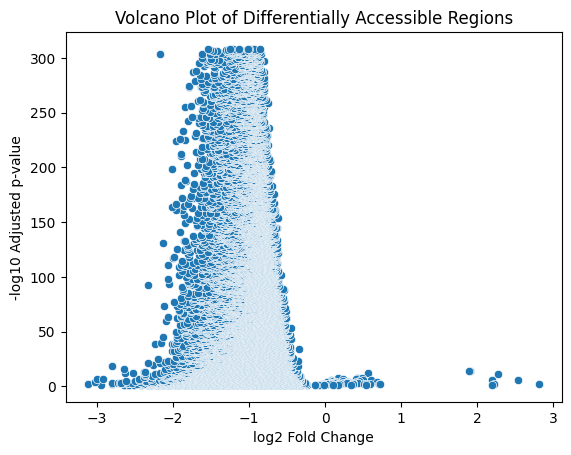

In [31]:
# Create scatterplot of differential accessibility results
sns.scatterplot(x=top_dars['logfoldchanges'], y=-np.log10(top_dars['pvals_adj']))
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted p-value')
plt.title('Volcano Plot of Differentially Accessible Regions')
plt.show()

In [32]:
# Display the top 10 DARs
print(top_10_dars)
print(bottom_10_dars)

                 names     scores  logfoldchanges  pvals  pvals_adj
27870  ENSG00000285708 -91.231148       -2.181107    0.0        0.0
26319        ADAM7-AS1 -43.084625       -1.475417    0.0        0.0
26318            NTNG2 -43.084198       -1.114267    0.0        0.0
26317            YWHAG -43.083111       -0.987811    0.0        0.0
26316             GLI2 -43.067299       -1.806581    0.0        0.0
26315           DUSP22 -43.067200       -1.117432    0.0        0.0
26314  ENSG00000284634 -43.062901       -1.049111    0.0        0.0
26320            PRKCZ -43.085884       -1.055056    0.0        0.0
26313             EML2 -43.060509       -1.183738    0.0        0.0
26311           CAMK2D -43.050148       -0.943554    0.0        0.0
              names    scores  logfoldchanges     pvals  pvals_adj
86  ENSG00000283355 -2.230343       -0.783072  0.025725   0.049477
85        RNU6-557P -2.228977       -1.155797  0.025815   0.049650
84  ENSG00000237371 -2.228603       -1.134785  0.02

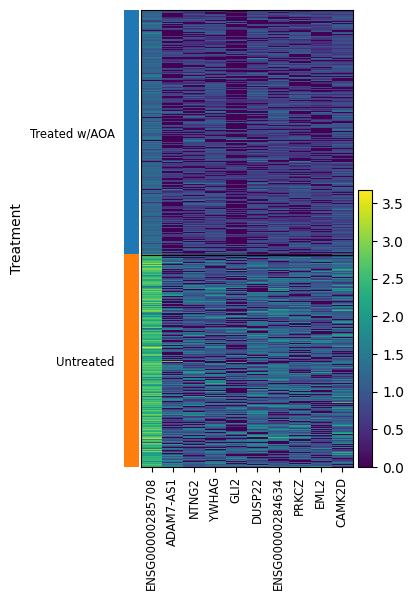

In [33]:
#Heatmap of top 10 differentially most expressed genes
sc.pl.heatmap(adata_concat, top_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

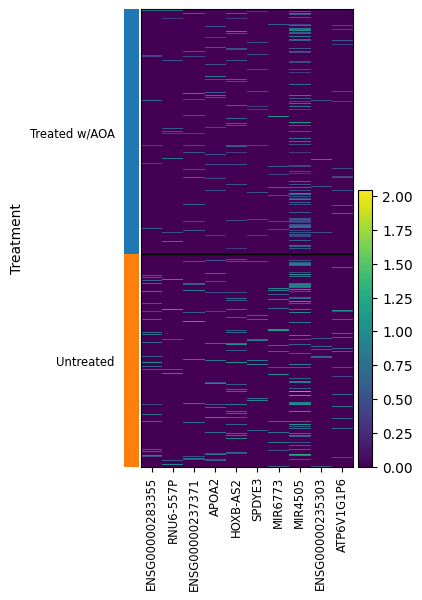

In [34]:
#Heatmap of top 10 differentially lowest expressed genes
sc.pl.heatmap(adata_concat, bottom_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

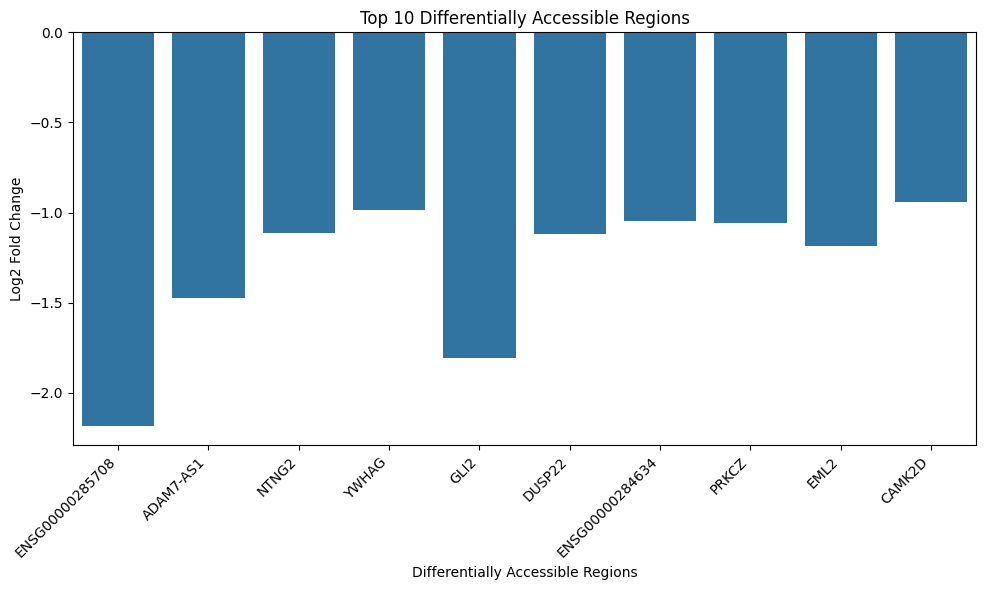

In [35]:
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=top_10_dars['names'].tolist(), y=top_10_dars['logfoldchanges'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Differentially Accessible Regions')
plt.ylabel('Log2 Fold Change')
plt.title('Top 10 Differentially Accessible Regions')
plt.tight_layout()
plt.show()

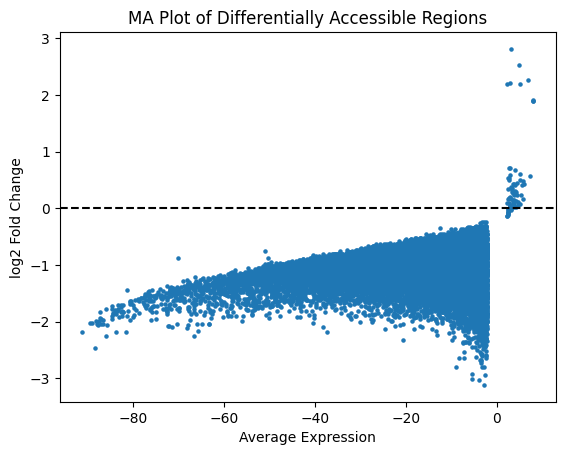

In [36]:
import matplotlib.pyplot as plt

# Assuming 'res_df' is your DataFrame of differential accessibility results
plt.scatter(top_dars['scores'], top_dars['logfoldchanges'], s=5)
plt.xlabel('Average Expression')
plt.ylabel('log2 Fold Change')
plt.title('MA Plot of Differentially Accessible Regions')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [37]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'MIR1302-2HG', 'MIR1302-2', 'ENSG00000238009',
       'ENSG00000239945', 'DDX11L17', 'WASH9P', 'ENSG00000228463',
       'ENSG00000286448',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53588)

Generating violin plots:   0%|          | 0/10 [00:00<?, ?it/s]

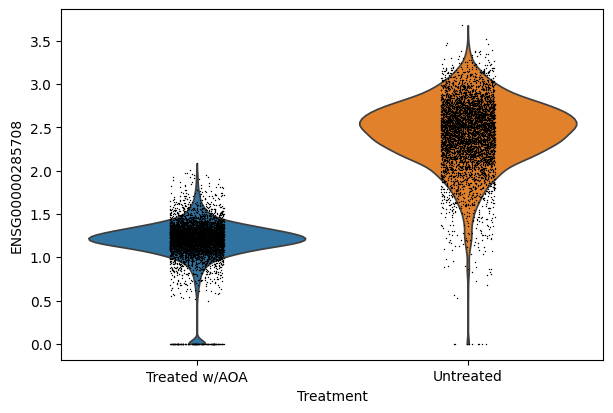

Generating violin plots:  10%|█         | 1/10 [00:00<00:04,  2.16it/s]

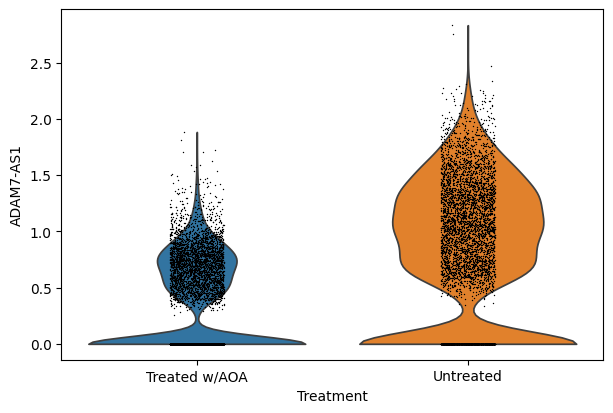

Generating violin plots:  20%|██        | 2/10 [00:00<00:03,  2.27it/s]

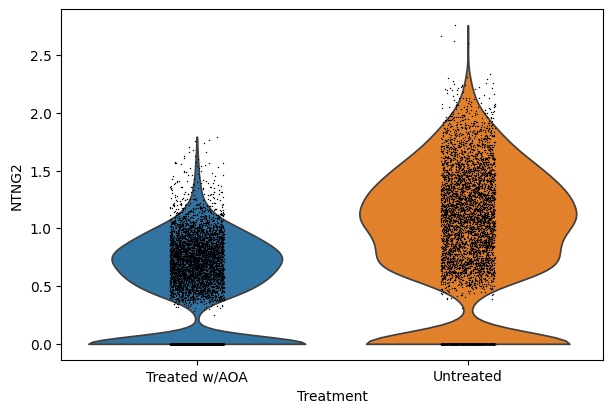

Generating violin plots:  30%|███       | 3/10 [00:01<00:03,  2.33it/s]

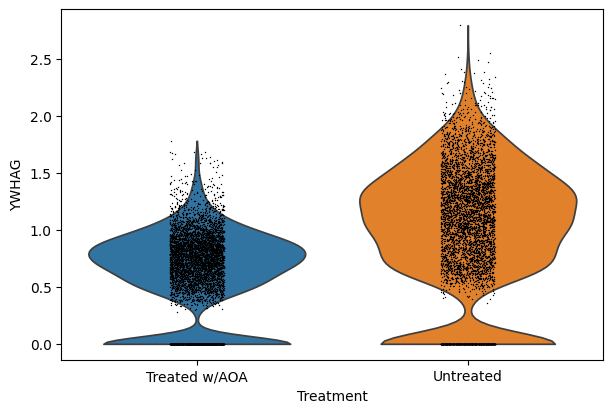

Generating violin plots:  40%|████      | 4/10 [00:01<00:02,  2.33it/s]

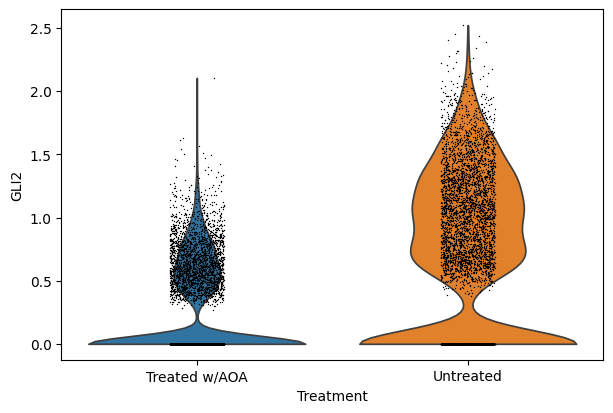

Generating violin plots:  50%|█████     | 5/10 [00:02<00:02,  2.36it/s]

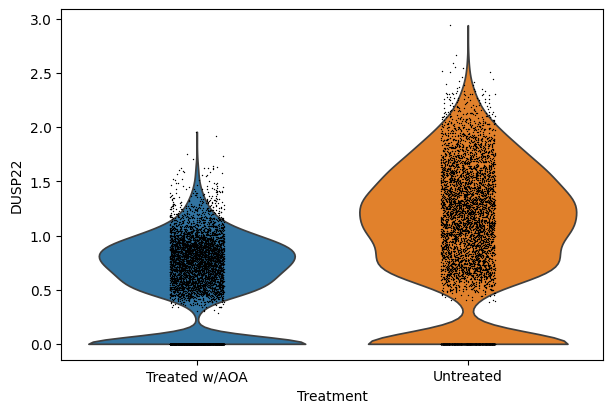

Generating violin plots:  60%|██████    | 6/10 [00:02<00:01,  2.31it/s]

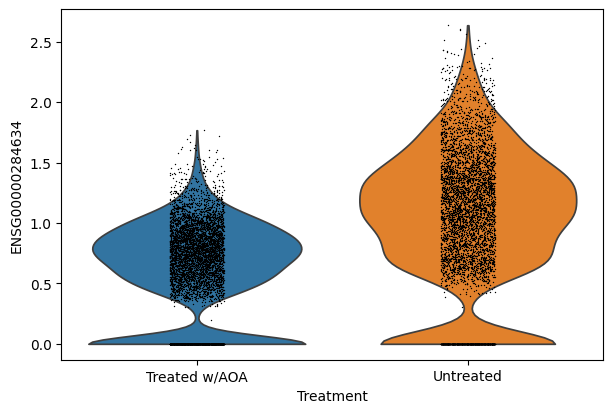

Generating violin plots:  70%|███████   | 7/10 [00:03<00:01,  2.27it/s]

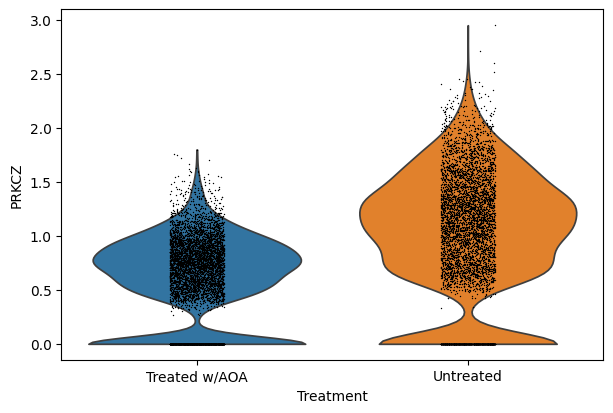

Generating violin plots:  80%|████████  | 8/10 [00:03<00:00,  2.30it/s]

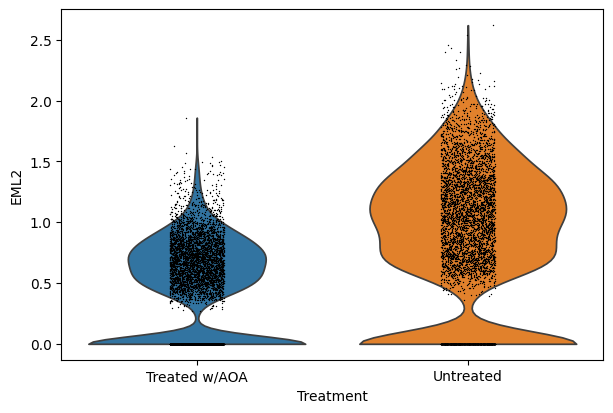

Generating violin plots:  90%|█████████ | 9/10 [00:03<00:00,  2.25it/s]

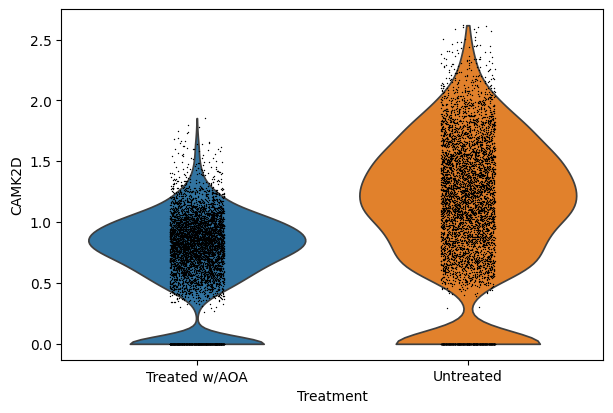

Generating violin plots: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


In [38]:
from tqdm import tqdm

for gene in tqdm(top_10_dars['names'].tolist(), desc="Generating violin plots"):
    sc.pl.violin(adata_concat, [gene], groupby='Treatment')

# Differential accessibility analysis using diffxpy

In [39]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import diffxpy.api as de

In [40]:
!pip install tf

ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python <4.0,>=3.11; 1.0.0 Requires-Python <4.0,>=3.11; 1.0.1 Requires-Python <4.0,>=3.11; 1.0.3 Requires-Python <4.0,>=3.11
ERROR: Could not find a version that satisfies the requirement tf (from versions: none)
ERROR: No matching distribution found for tf


In [41]:
import diffxpy
print(diffxpy.__file__)

/usr/local/lib/python3.10/site-packages/diffxpy/__init__.py


In [42]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print(f"Current working directory: {current_directory}")

Current working directory: /content


In [43]:
#numpy type aliases
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [44]:
test_tt = de.test.t_test(
    data=adata_concat,
    grouping="Treatment"
)

In [45]:
test_tt.summary()

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,DDX11L1,0.999999,1.0,-1046.803853,-5.387499e-10,False,False
1,WASH7P,1.000000,1.0,0.000000,-9.198326e-09,False,False
2,MIR1302-2HG,0.999999,1.0,-1048.079533,8.420841e-09,False,False
3,MIR1302-2,0.999999,1.0,-1048.079533,8.420841e-09,False,False
4,ENSG00000238009,0.999999,1.0,-1045.981870,-3.955089e-09,False,False
...,...,...,...,...,...,...,...
53583,MT-ND6,1.000000,1.0,0.912236,6.633519e-09,False,False
53584,MT-TE,1.000000,1.0,-2.343741,6.133069e-09,False,False
53585,MT-CYB,1.000000,1.0,0.000000,-2.849502e-09,False,False
53586,MT-TT,1.000000,1.0,4.234340,5.050462e-09,False,False


In [50]:
# Sort by adjusted p-value in ascending order (most significant first)
top_dars_sorted = test_tt.summary().sort_values(by='qval')

In [51]:
# Select the top 10 rows
top_10_dars = top_dars_sorted.head(10)
bottom_10_dars = top_dars_sorted.tail(10)

In [52]:
top_10_dars

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,DDX11L1,0.999999,1.0,-1046.803853,-5.387499e-10,False,False
35720,ENSG00000276269,0.967825,1.0,0.000000,-3.464799e-04,False,False
35721,LINC00396,1.000000,1.0,-1046.687052,1.851155e-09,False,False
35722,ENSG00000279965,1.000000,1.0,0.000000,-1.173888e-09,False,False
35723,ENSG00000287575,1.000000,1.0,0.969221,3.641031e-09,False,False
35724,COL4A1,0.999998,1.0,1049.069554,1.117842e-08,False,False
35725,ENSG00000279237,1.000000,1.0,0.000000,-5.285367e-09,False,False
35726,COL4A2,0.999999,1.0,-1048.322759,8.256153e-09,False,False
35727,MIR8073,1.000000,1.0,0.000000,-4.999396e-09,False,False
35728,COL4A2-AS2,1.000000,1.0,0.000000,-3.330803e-09,False,False


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



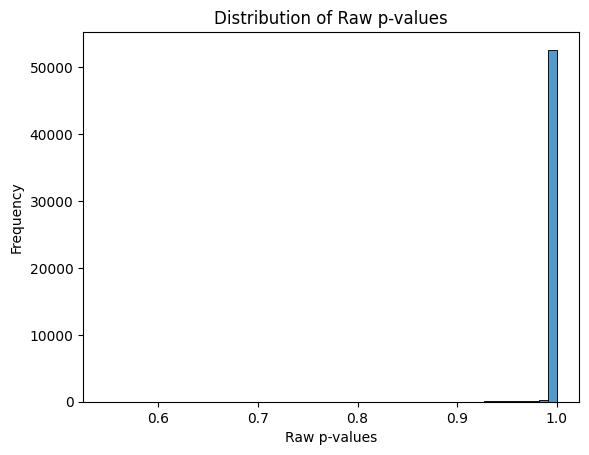

Proportion of p-values below 0.05: 0.0


In [54]:
# Get raw p-values from the test results
p_values = test_tt.summary()['pval']

# Plot the distribution of p-values
sns.histplot(p_values, bins=50)
plt.xlabel("Raw p-values")
plt.ylabel("Frequency")
plt.title("Distribution of Raw p-values")
plt.show()

# Check the proportion of p-values below a threshold (e.g., 0.05)
proportion_below_threshold = (p_values < 0.05).mean()
print(f"Proportion of p-values below 0.05: {proportion_below_threshold}")